### Machine Learning for Finance - Regression
#### Forecasting Credit Card Default

## Dataset description

- **IDpol**: The policy ID (used to link with the claims dataset).
- **ClaimNb**: Number of claims during the exposure period.
- **Exposure**: The exposure period.
- **Area**: The area code.
- **VehPower**: The power of the car (ordered categorical).
- **VehAge**: The vehicle age, in years.
- **DrivAge**: The driver age, in years (in France, people can drive a car at 18).
- **BonusMalus**: Bonus/malus, between 50 and 350: <100 means bonus, >100 means malus in France.
- **VehBrand**: The car brand (unknown categories).
- **VehGas**: The car gas, Diesel or regular.
- **Density**: The density of inhabitants (number of inhabitants per km2) in the city the driver of the car lives in.
- **Region**: The policy regions in France (based on a standard French classification)



## Work description

Employing the CRISP-DM process model, you are expected to define, describe and explain the model built. Simultaneous, you should explain how your model can help the insurance company reaching its objectives.</p>

Crisp-DM: Business understanding
This initial phase focuses on understanding the project objectives and requirements from a business perspective,
then converting this knowledge into a data mining problem definition and a preliminary plan designed to achieve
the objectives

### Overview
Develop a model to forecast how many claims will each policy holder from a car insurer in France have in the following year. The insurance company wants to use this model to improve the policies' premiums (pricing).</p>
<p>

## Initializations and data loading

Crisp-DM: Data understanding
The data understanding phase starts with initial data collection and proceeds with activities that enable you to
become familiar with the data, identify data quality problems, discover first insights into the data, and / or detect
interesting subsets to form hypotheses regarding hidden information.

The XB group focused on see the type of data, specially the numerical x categorical. Also try to finding patterns between the features. The decision is to prepare the data specially for the viewing process only. The next phase we will load the data again. The findings of this phase will support the data preparation in the next phase.


In [1]:
# Loading packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
import math
from copy import deepcopy
from sklearn import tree



In [2]:
!pip3 install yellowbrick

In [3]:
from yellowbrick.model_selection import RFECV
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.model_selection import LearningCurve


In [4]:
# Loading the dataset and visualizing summary statistics
ds_raw = pd.read_csv('freMTPL2freq.csv')

In [5]:
# Check input data types
ds_raw.dtypes

IDpol         float64
ClaimNb         int64
Exposure      float64
Area           object
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Density         int64
Region         object
dtype: object

In [6]:
#Change Idpol from float to object
ds_raw['IDpol'] = ds_raw['IDpol'].astype(object)


In [7]:
# Summary statistics for all variables - Transpose
ds_raw.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IDpol,678013.0,678013.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ClaimNb,678013.0,NaN,NaN,NaN,0.053247,0.240117,0.0,0.0,0.0,0.0,16.0
Exposure,678013.0,NaN,NaN,NaN,0.52875,0.364442,0.002732,0.18,0.49,0.99,2.01
Area,678013,6,C,191880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehPower,678013.0,NaN,NaN,NaN,6.454631,2.050906,4.0,5.0,6.0,7.0,15.0
VehAge,678013.0,NaN,NaN,NaN,7.044265,5.666232,0.0,2.0,6.0,11.0,100.0
DrivAge,678013.0,NaN,NaN,NaN,45.499122,14.137444,18.0,34.0,44.0,55.0,100.0
BonusMalus,678013.0,NaN,NaN,NaN,59.761502,15.636658,50.0,50.0,50.0,64.0,230.0
VehBrand,678013,11,B12,166024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehGas,678013,2,Regular,345877,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Prepare the data for view (ds_view)
#Optimized bin counts for BonusMalus, capped DriverAge, capped VehicleAge 

ds_view = ds_raw
ds_view['ClaimNb'] = ds_view['ClaimNb'].apply(lambda x: 3 if x > 3 else x)
ds_view['VehAge'] = ds_view['VehAge'].apply(lambda x: 20 if x > 20 else x)
ds_view['BonusMalus'] = ds_view['BonusMalus'].apply(
    lambda x: 150 if x > 150 else round(x / 10) * 10)
ds_view['Density'] = ds_view['Density'].apply(lambda x: round(math.log(x)))
ds_view['Exposure'] = ds_view['Exposure'].apply(lambda x: 1. if x > 1 else x)



In [9]:
ds_view.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.053155,0.528545,6.454631,6.976124,45.499122,59.740801,5.956151
std,0.237612,0.364081,2.050906,5.398963,14.137444,15.899992,1.867370
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,0.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,5.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,6.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,60.000000,7.000000
max,3.000000,1.000000,15.000000,20.000000,100.000000,150.000000,10.000000


In [10]:
#Checking ClaimNb equal 0 x >0
#We have 95% of 0 ClaimNb
ds_view['frequency'] = ds_view['ClaimNb'] / ds_view['Exposure']
ds_view_clm = ds_view[ds_view['ClaimNb'] > 0]
print('All records: ' + str(len(ds_view)))
print('All records with zero ClaimNb: ' +
      str(len(ds_view[ds_view['ClaimNb'] == 0])))
print('All records with non-zero ClaimNb: ' + str(len(ds_view_clm)))

All records: 678013
All records with zero ClaimNb: 643953
All records with non-zero ClaimNb: 34060


,Exposure
ExposureGrp,
Full Year,24.97725
not Full Year,75.02275


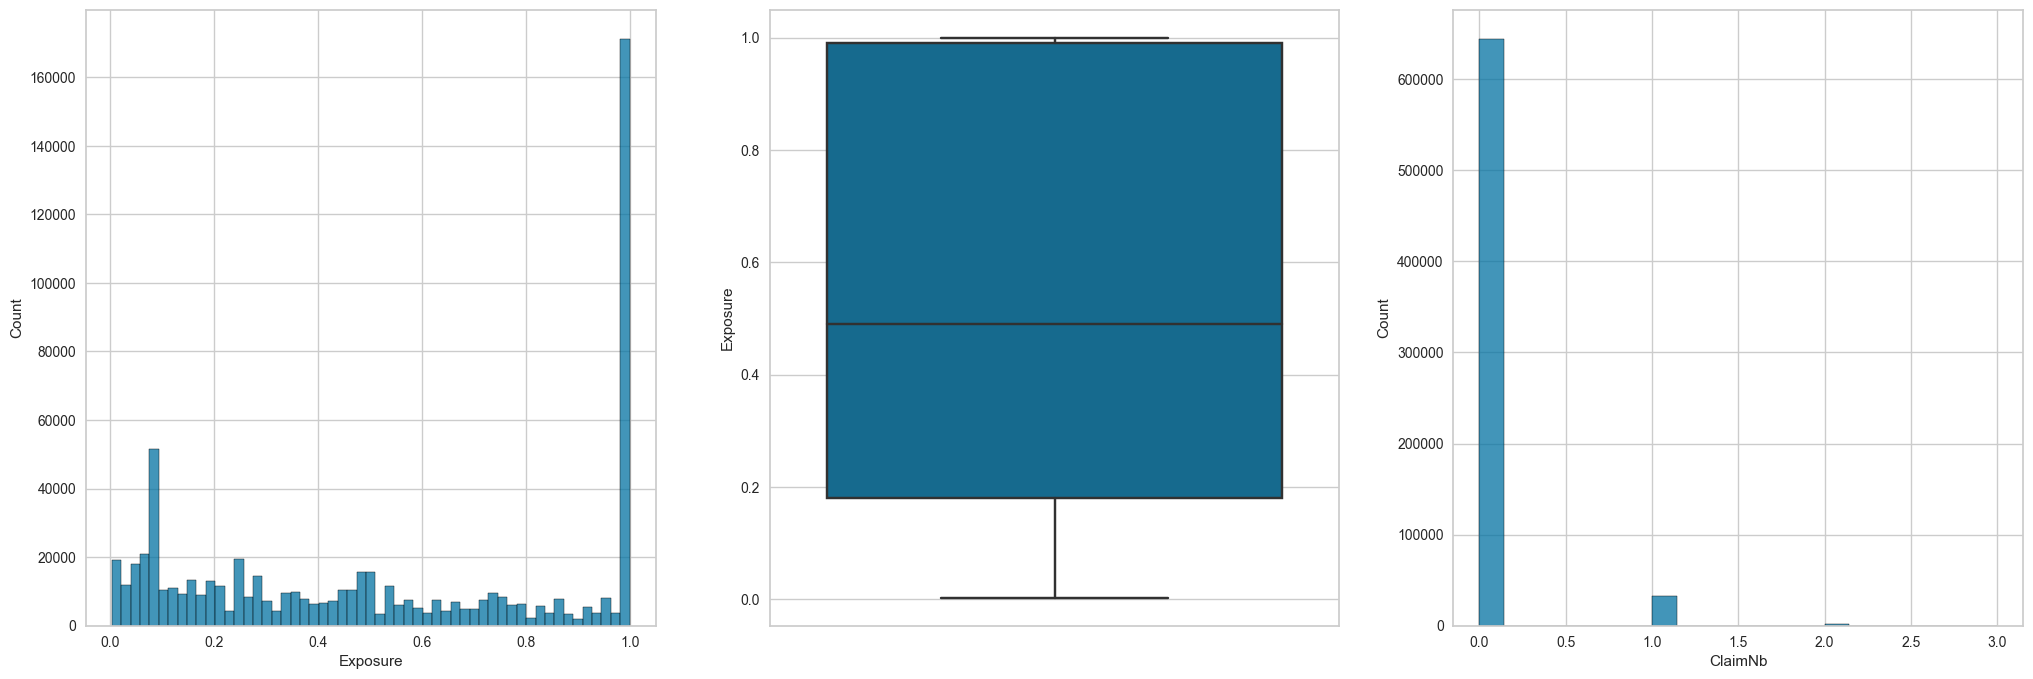

In [11]:
# View - Take a lot at plots
plt.subplots(nrows=1, ncols=3, figsize=(25, 8))
plt.subplot(1, 3, 1)
sns.histplot(ds_view, x='Exposure')
plt.subplot(1, 3, 2)
sns.boxplot(y="Exposure", data=ds_view)
plt.subplot(1, 3, 3)
sns.histplot(ds_view, x='ClaimNb')
ds_view['ExposureGrp'] = ds_view['Exposure'].apply(
    lambda x: 'Full Year' if x == 1 else 'not Full Year')
ds_view[['Exposure', 'ExposureGrp']].groupby(
    'ExposureGrp').count().apply(lambda x: 100 * x / float(x.sum()))


<AxesSubplot: xlabel='Exposure', ylabel='Count'>

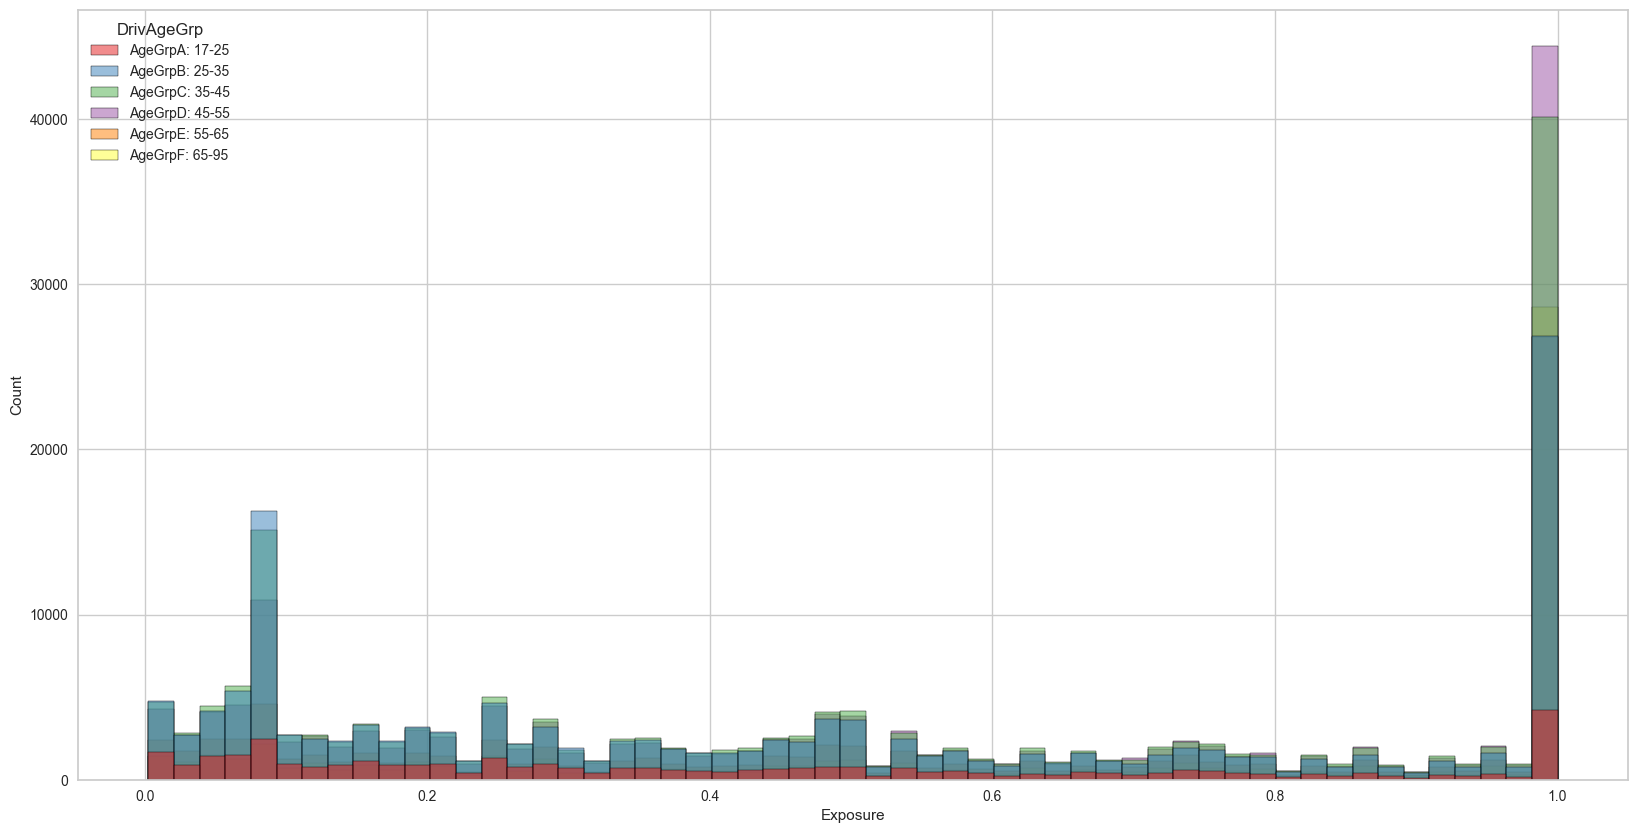

In [12]:
# Plot on Exposure and Driver Age
bins = [17, 25, 35, 45, 55, 65, 95]
labels = ['AgeGrpA: 17-25', 'AgeGrpB: 25-35', 'AgeGrpC: 35-45',
          'AgeGrpD: 45-55', 'AgeGrpE: 55-65', 'AgeGrpF: 65-95']
ds_view['DrivAgeGrp'] = pd.cut(ds_view['DrivAge'], bins=bins, labels=labels)
plt.figure(figsize=(20, 10))
sns.histplot(ds_view, x='Exposure', hue='DrivAgeGrp', palette='Set1')


<AxesSubplot: xlabel='BonusMalus', ylabel='Exposure'>

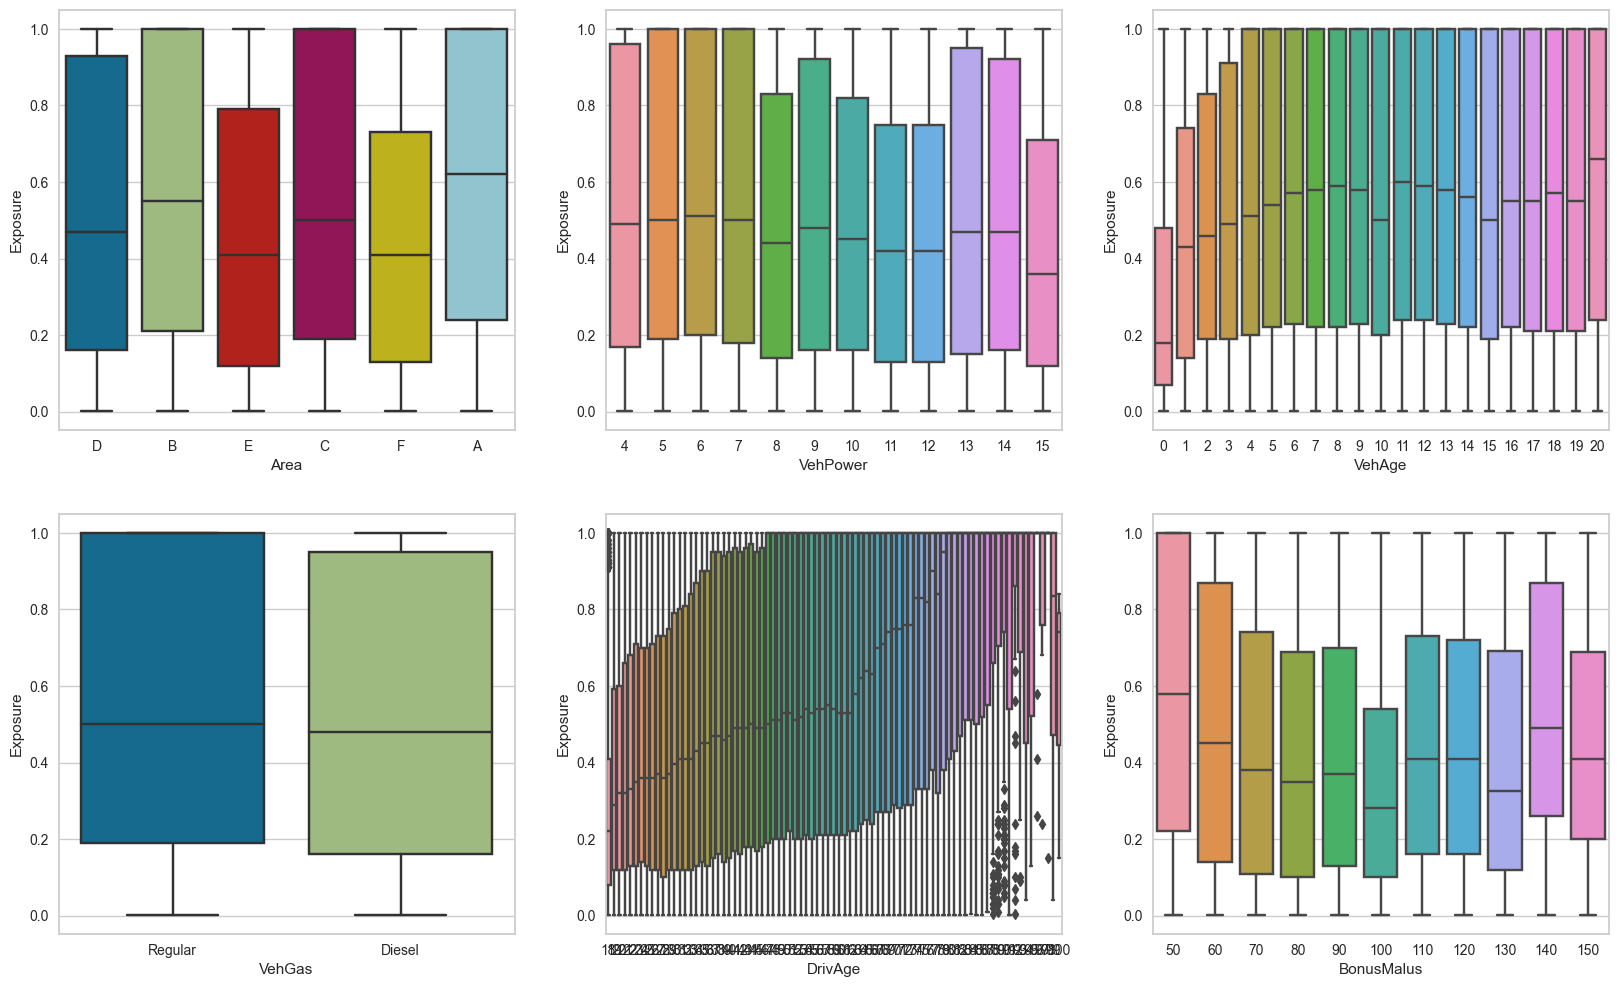

In [13]:
# Going deeper in the plots
plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
plt.subplot(2, 3, 1)
sns.boxplot(y='Exposure', x='Area', data=ds_view)
plt.subplot(2, 3, 2)
sns.boxplot(y='Exposure', x='VehPower', data=ds_view)
plt.subplot(2, 3, 3)
sns.boxplot(y='Exposure', x='VehAge', data=ds_view)
plt.subplot(2, 3, 4)
sns.boxplot(y='Exposure', x='VehGas', data=ds_view)
plt.subplot(2, 3, 5)
sns.boxplot(y='Exposure', x='DrivAge', data=ds_view)
plt.subplot(2, 3, 6)
sns.boxplot(y='Exposure', x='BonusMalus', data=ds_view)


array([[<AxesSubplot: title={'center': 'ClaimNb'}>,
        <AxesSubplot: title={'center': 'Exposure'}>,
        <AxesSubplot: title={'center': 'VehPower'}>,
        <AxesSubplot: title={'center': 'VehAge'}>],
       [<AxesSubplot: title={'center': 'DrivAge'}>,
        <AxesSubplot: title={'center': 'BonusMalus'}>,
        <AxesSubplot: title={'center': 'Density'}>,
        <AxesSubplot: title={'center': 'frequency'}>],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >],
       [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

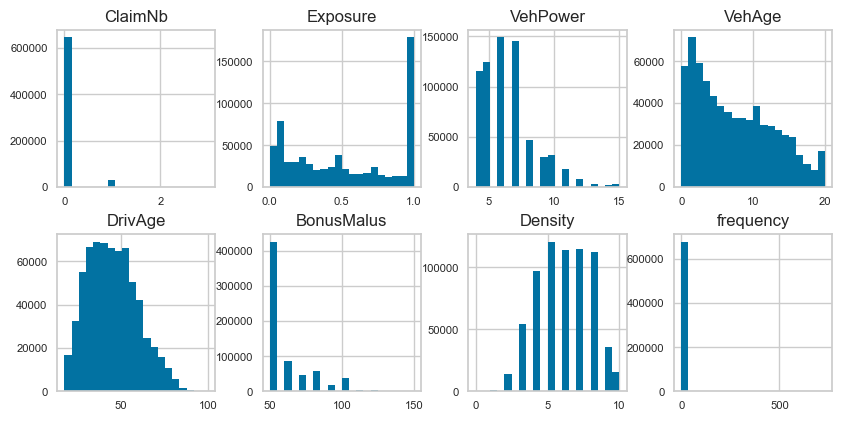

In [14]:
# Do histograms on all numeric variables to identify patterns
numerical = ds_view.select_dtypes(include=[np.number]).columns.tolist()
ds_view[numerical].hist(bins=20, figsize=(10, 10), layout=(4, 4),
                   xlabelsize=8, ylabelsize=8)


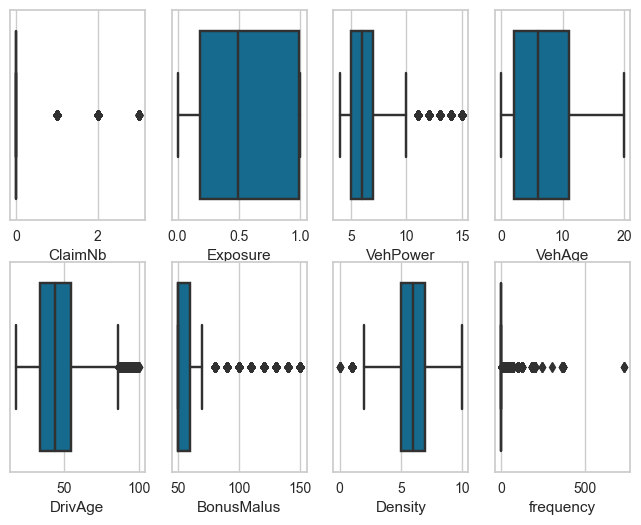

In [15]:
# Do boxplots on all numeric variables to identify patterns
fig, ax = plt.subplots(2, 4, figsize=(8, 6))
for var, subplot in zip(ds_view[numerical], ax.flatten()):
    sns.boxplot(x=ds_view[var], ax=subplot)


/var/folders/vf/jq8vy8s53s3dcps4_m3vnmnw0000gn/T/ipykernel_6677/2750188768.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


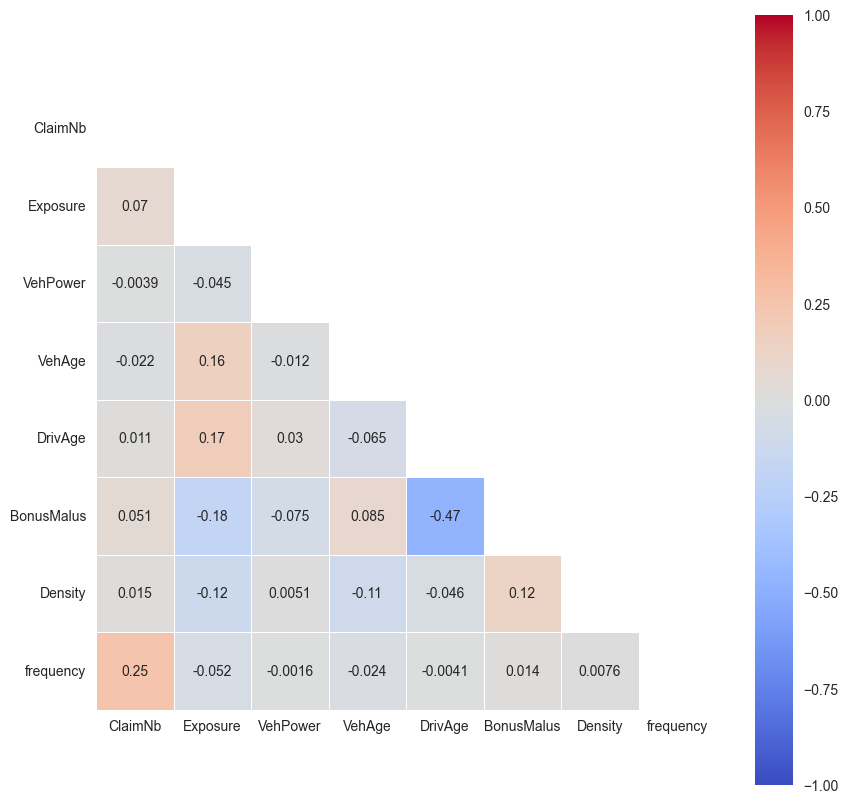

In [16]:
##### Calculate the Pearson Correlation
corr = ds_view[numerical].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))
heatmap = sns.heatmap(corr,
                      mask=mask,
                      square=True,
                      linewidths=.5,
                      cmap='coolwarm',
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size': 10})

# add the column names as labels
ax.set_yticklabels(corr.columns, rotation=0)
ax.set_xticklabels(corr.columns, rotation=0)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})



In [17]:
# Pair plot some of the numerical variables with ClaimNb
#cols = ['Exposure', 'BonusMalus','ClaimNb']
#g = sns.pairplot(ds_view[cols], hue="ClaimNb")


Findings: Based on the data undestand from the charts we will model the next phase:
Simplify the data outliers after view checking:
ClaimNb - maximum of 3 / VehAge - maximum 20 years / DrivAge - minimum 18 years and maximum 90 years / BonusMalus - maximum 150 / Exposure - maximum 1 year

There is a BonusMalus correlation with DrivAge.
The reason of this observation is based on the fact that BonusMalus is connected to the driver experience.

The 95% of Number of Claims equal to zero can be an issue. We will user feature engineering (SMOTE) to improve.






#### Data Preparation
Crisp-DM: The data preparation phase covers all activities needed to construct the final dataset [data that will be fed into the
modeling tool(s)] from the initial raw data. Data preparation tasks are likely to be performed multiple times and not
in any prescribed order. Tasks include table, record, and attribute selection, as well as transformation and cleaning
of data for modeling tools.

The XB group decide to load the data again specially fot the data preparation. This can be a good tip to avoid noisy from the data understanding process.
The missing values checked was 100% ok.
For the outliers the group decide to use the information from Data Understanding.

The categorical data will be converted to dummy variables.
The data will be normalized for the modeling process.
#### Come back with the original Data (ds_raw)

In [18]:
#check if we have the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
#import plotly.express as px
from scipy import stats
from copy import deepcopy
from sklearn.model_selection import GroupShuffleSplit
from sklearn.datasets import fetch_openml


In [19]:
ds_raw = pd.read_csv('freMTPL2freq.csv')


In [20]:
# Confirm that there are not any missing values
print(ds_raw.isnull().sum())


IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64


In [21]:
# Summary statistics for all variables - Transpose
ds_raw.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IDpol,678013.0,NaN,NaN,NaN,2621856.921071,1641782.752655,1.0,1157951.0,2272152.0,4046274.0,6114330.0
ClaimNb,678013.0,NaN,NaN,NaN,0.053247,0.240117,0.0,0.0,0.0,0.0,16.0
Exposure,678013.0,NaN,NaN,NaN,0.52875,0.364442,0.002732,0.18,0.49,0.99,2.01
Area,678013,6,C,191880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehPower,678013.0,NaN,NaN,NaN,6.454631,2.050906,4.0,5.0,6.0,7.0,15.0
VehAge,678013.0,NaN,NaN,NaN,7.044265,5.666232,0.0,2.0,6.0,11.0,100.0
DrivAge,678013.0,NaN,NaN,NaN,45.499122,14.137444,18.0,34.0,44.0,55.0,100.0
BonusMalus,678013.0,NaN,NaN,NaN,59.761502,15.636658,50.0,50.0,50.0,64.0,230.0
VehBrand,678013,11,B12,166024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehGas,678013,2,Regular,345877,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data processing - Regression Linear Model

In [22]:
ds_lin = ds_raw

In [23]:
ds_lin.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IDpol,678013.0,NaN,NaN,NaN,2621856.921071,1641782.752655,1.0,1157951.0,2272152.0,4046274.0,6114330.0
ClaimNb,678013.0,NaN,NaN,NaN,0.053247,0.240117,0.0,0.0,0.0,0.0,16.0
Exposure,678013.0,NaN,NaN,NaN,0.52875,0.364442,0.002732,0.18,0.49,0.99,2.01
Area,678013,6,C,191880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehPower,678013.0,NaN,NaN,NaN,6.454631,2.050906,4.0,5.0,6.0,7.0,15.0
VehAge,678013.0,NaN,NaN,NaN,7.044265,5.666232,0.0,2.0,6.0,11.0,100.0
DrivAge,678013.0,NaN,NaN,NaN,45.499122,14.137444,18.0,34.0,44.0,55.0,100.0
BonusMalus,678013.0,NaN,NaN,NaN,59.761502,15.636658,50.0,50.0,50.0,64.0,230.0
VehBrand,678013,11,B12,166024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehGas,678013,2,Regular,345877,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
ds_lin.head(15)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72
5,13.0,1,0.52,E,6,2,38,50,B12,Regular,3003,R31
6,15.0,1,0.45,E,6,2,38,50,B12,Regular,3003,R31
7,17.0,1,0.27,C,7,0,33,68,B12,Diesel,137,R91
8,18.0,1,0.71,C,7,0,33,68,B12,Diesel,137,R91
9,21.0,1,0.15,B,7,0,41,50,B12,Diesel,60,R52


In [25]:
ds_lin

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10000,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77000,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75000,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09000,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84000,B,7,0,46,50,B12,Diesel,76,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326.0,0,0.00274,E,4,0,54,50,B12,Regular,3317,R93
678009,6114327.0,0,0.00274,E,4,0,41,95,B12,Regular,9850,R11
678010,6114328.0,0,0.00274,D,6,2,45,50,B12,Diesel,1323,R82
678011,6114329.0,0,0.00274,B,4,0,60,50,B12,Regular,95,R26


In [26]:
# Simplify the data outliers after view checking
# ClaimNb - maximum of 3
# VehAge - maximum of 20 and change the 0 and 1 to 2 (for the binned column)
# DrivAge - minimum 18 years and maximum 90 years
# BonusMalus - maximum 150
# Exposure - chang 0 to 0.18


In [27]:
ds_lin['ClaimNb'] = ds_lin['ClaimNb'].apply(lambda x: 3 if x > 3 else x)
ds_lin['VehAge'] = ds_lin['VehAge'].apply(lambda x: 2 if x < 2 else x)
ds_lin['BonusMalus'] = ds_lin['BonusMalus'].apply(
    lambda x: 150 if x > 150 else int(x))
ds_lin['Exposure'] = ds_lin['Exposure'].apply(lambda x: 0.18 if x < 0.18 else x)
ds_lin['DrivAge'] = ds_lin['DrivAge'].apply(lambda x: 90 if x > 90 else x)
ds_lin['DrivAge'] = ds_lin['DrivAge'].apply(lambda x: 18 if x < 18 else x)

ds_lin['VehAge'] = ds_lin['VehAge'].apply(lambda x: 20 if x > 20 else x)
ds_lin['Exposure'] = ds_lin['Exposure'].apply(lambda x: 1. if x > 1 else x)


In [28]:
# Bin the VehAge
# Create bins interval based on distribution/quartiles
ds_lin['VehAge']
binsInterval = [0, 2, 6, 11, 100]
intervalLabels = ['(0, 2]', '(2, 6]',  '(6, 11]', '(11, 100]']
ds_lin['VehAge_binned'] = pd.cut(
    ds_lin['VehAge'], bins=binsInterval, labels=intervalLabels)

# Bin the Exposure
# Create bins interval based on distribution/quartiles
ds_lin['Exposure']
binsInterval = [0, 0.18, 0.49, 2.1]
intervalLabels = ['(0, 0.18]', '(0.18, 0.49]', '(0.49, 2.1]']
ds_lin['Exposure_binned'] = pd.cut(
    ds_lin['Exposure'], bins=binsInterval, labels=intervalLabels)

# Bin the DrivAge
# Create bins interval based on distribution/quartiles
ds_lin['DrivAge']
binsInterval = [17, 34, 44,55,100]
intervalLabels = ['(17, 34]', '(34, 44]', '(44, 55]', '(55,100]']
ds_lin['DrivAge_binned'] = pd.cut(
    ds_lin['DrivAge'], bins=binsInterval, labels=intervalLabels)

# Bin the BonusMalus
# Create bins interval based on distribution/quartiles
ds_lin['BonusMalus']
binsInterval = [49, 64, 230]
intervalLabels = ['(49, 64]', '(64, 230]']
ds_lin['BonusMalus_binned'] = pd.cut(
    ds_lin['BonusMalus'], bins=binsInterval, labels=intervalLabels)

# Bin the VehPower
# Create bins interval based on distribution/quartiles
ds_lin['VehPower']
binsInterval = [3, 5, 6, 7, 15]
intervalLabels = ['(3, 5]', '(5, 6]', '(6, 7]', '(7, 15]']
ds_lin['VehPower_binned'] = pd.cut(
    ds_lin['VehPower'], bins=binsInterval, labels=intervalLabels)

# Bin the Density
# Create bins interval based on distribution/quartiles
ds_lin['Density']
binsInterval = [0, 92, 393, 1658, 27000]
intervalLabels = ['(0, 92]', '(92, 393]', '(393, 1658]', '(1658, 28000]']
ds_lin['Density_binned'] = pd.cut(
    ds_lin['Density'], bins=binsInterval, labels=intervalLabels)



In [29]:
ds_lin.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IDpol,678013.0,NaN,NaN,NaN,2621856.921071,1641782.752655,1.0,1157951.0,2272152.0,4046274.0,6114330.0
ClaimNb,678013.0,NaN,NaN,NaN,0.053155,0.237612,0.0,0.0,0.0,0.0,3.0
Exposure,678013.0,NaN,NaN,NaN,0.553898,0.333478,0.18,0.18,0.49,0.99,1.0
Area,678013,6,C,191880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehPower,678013.0,NaN,NaN,NaN,6.454631,2.050906,4.0,5.0,6.0,7.0,15.0
VehAge,678013.0,NaN,NaN,NaN,7.251579,5.087804,2.0,2.0,6.0,11.0,20.0
DrivAge,678013.0,NaN,NaN,NaN,45.496871,14.129872,18.0,34.0,44.0,55.0,90.0
BonusMalus,678013.0,NaN,NaN,NaN,59.757211,15.607906,50.0,50.0,50.0,64.0,150.0
VehBrand,678013,11,B12,166024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehGas,678013,2,Regular,345877,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Transform a list of columns to categorical
cols = ['Area', 'VehBrand', 'VehGas', 'Region','VehAge_binned','BonusMalus_binned','Density_binned']
ds_lin[cols] = ds_lin[cols].apply(lambda x:x.astype('category'))

In [31]:
# Ckeck the top counts of all categorical variables
categorical=ds_lin.select_dtypes(exclude=["number","bool_","object_"]).columns.tolist()
categorical
for var in ds_lin[categorical]:
    print(var,":\n",ds_lin[var].value_counts(), sep="")

Area:
C    191880
D    151596
E    137167
A    103957
B     75459
F     17954
Name: Area, dtype: int64
VehBrand:
B12    166024
B1     162736
B2     159861
B3      53395
B5      34753
B6      28548
B4      25179
B10     17707
B11     13585
B13     12178
B14      4047
Name: VehBrand, dtype: int64
VehGas:
Regular    345877
Diesel     332136
Name: VehGas, dtype: int64
Region:
R24    160601
R82     84752
R93     79315
R11     69791
R53     42122
R52     38751
R91     35805
R72     31329
R31     27285
R54     19046
R73     17141
R41     12990
R25     10893
R26     10492
R23      8784
R22      7994
R83      5287
R74      4567
R94      4516
R21      3026
R42      2200
R43      1326
Name: Region, dtype: int64
VehAge_binned:
(0, 2]       188147
(2, 6]       168207
(6, 11]      165307
(11, 100]    156352
Name: VehAge_binned, dtype: int64
Exposure_binned:
(0.49, 2.1]     336396
(0, 0.18]       174616
(0.18, 0.49]    167001
Name: Exposure_binned, dtype: int64
DrivAge_binned:
(44, 55]    178606
(17,

In [32]:
# Create a modeling dataset from the original dataset
X = ds_lin.copy(deep=True)


In [33]:
# Encode boolean features into dummy variables
cols = ['VehGas']
X = pd.get_dummies(data=X,columns=cols,drop_first=True)

In [34]:
import numpy as np
import pandas as pd              # version 0.23.4
import category_encoders as ce   # version 1.2.8
from sklearn.preprocessing import LabelEncoder


In [35]:
# Encode categorical values into dummy
# Encode categorical values into dummy variables
cols = ['Area', 'Region', 'VehBrand', 'VehAge_binned', 'Exposure_binned','DrivAge_binned', 'BonusMalus_binned', 'VehPower_binned', 'Density_binned']
ce_one_hot = ce.OneHotEncoder(cols=cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)


In [36]:
X.head(10)

,IDpol,ClaimNb,Exposure,Area_D,Area_B,Area_E,Area_C,Area_F,Area_A,VehPower,...,"BonusMalus_binned_(64, 230]","VehPower_binned_(3, 5]","VehPower_binned_(5, 6]","VehPower_binned_(6, 7]","VehPower_binned_(7, 15]","Density_binned_(0, 92]","Density_binned_(92, 393]","Density_binned_(393, 1658]","Density_binned_(1658, 28000]",VehGas_Regular
0,1.0,1,0.18,1,0,0,0,0,0,5,...,0,1,0,0,0,0,0,1,0,1
1,3.0,1,0.77,1,0,0,0,0,0,5,...,0,1,0,0,0,0,0,1,0,1
2,5.0,1,0.75,0,1,0,0,0,0,6,...,0,0,1,0,0,1,0,0,0,0
3,10.0,1,0.18,0,1,0,0,0,0,7,...,0,0,0,1,0,1,0,0,0,0
4,11.0,1,0.84,0,1,0,0,0,0,7,...,0,0,0,1,0,1,0,0,0,0
5,13.0,1,0.52,0,0,1,0,0,0,6,...,0,0,1,0,0,0,0,0,1,1
6,15.0,1,0.45,0,0,1,0,0,0,6,...,0,0,1,0,0,0,0,0,1,1
7,17.0,1,0.27,0,0,0,1,0,0,7,...,1,0,0,1,0,0,1,0,0,0
8,18.0,1,0.71,0,0,0,1,0,0,7,...,1,0,0,1,0,0,1,0,0,0
9,21.0,1,0.18,0,1,0,0,0,0,7,...,0,0,0,1,0,1,0,0,0,0


In [37]:
# Create the target
y = X['ClaimNb']

In [38]:
# Drop the target and IDpol - no logical correlation
# Drop the original features not used
cols = ['ClaimNb','IDpol', 'VehAge', 'Exposure', 'DrivAge', 'VehPower', 'BonusMalus', 'Density']
X = X.drop(columns=cols)
ds_dt = X

In [39]:
# Summary statistics for all variables after data preparation - Transpose
X.describe(include='all').T


,count,mean,std,min,25%,50%,75%,max
Area_D,678013.0,0.223589,0.416650,0.0,0.0,0.0,0.0,1.0
Area_B,678013.0,0.111294,0.314496,0.0,0.0,0.0,0.0,1.0
Area_E,678013.0,0.202307,0.401720,0.0,0.0,0.0,0.0,1.0
Area_C,678013.0,0.283003,0.450458,0.0,0.0,0.0,1.0,1.0
Area_F,678013.0,0.026480,0.160559,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
"Density_binned_(0, 92]",678013.0,0.250693,0.433412,0.0,0.0,0.0,1.0,1.0
"Density_binned_(92, 393]",678013.0,0.251093,0.433642,0.0,0.0,0.0,1.0,1.0
"Density_binned_(393, 1658]",678013.0,0.248455,0.432118,0.0,0.0,0.0,0.0,1.0
"Density_binned_(1658, 28000]",678013.0,0.249759,0.432874,0.0,0.0,0.0,0.0,1.0


In [40]:
X.head()


,Area_D,Area_B,Area_E,Area_C,Area_F,Area_A,VehBrand_B12,VehBrand_B6,VehBrand_B3,VehBrand_B2,...,"BonusMalus_binned_(64, 230]","VehPower_binned_(3, 5]","VehPower_binned_(5, 6]","VehPower_binned_(6, 7]","VehPower_binned_(7, 15]","Density_binned_(0, 92]","Density_binned_(92, 393]","Density_binned_(393, 1658]","Density_binned_(1658, 28000]",VehGas_Regular
0,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [41]:
X.shape

(678013, 61)

### Modeling
Crisp-DM: In this phase, various modeling techniques are selected and applied, and their parameters are calibrated to optimal
values. Typically, there are several techniques for the same data mining problem type. Some techniques have specific
requirements on the form of data. Therefore, going back to the data preparation phase is often necessary.

The XG Group decide to use the Linear Regression and Decision Tree models. After the generation of the Linear Regression model the group will reset the data to assure the consistency of the data to apply in the Decision Tree model.

The group decided to apply SMOTE to improve the sample, considering the 95% of ClaimNb = 0.

 

In [42]:
# Split the dataset intro train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, test_size=0.20, random_state=123)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=14)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)



In [43]:
# Initialize model
lr_regr = linear_model.LinearRegression()


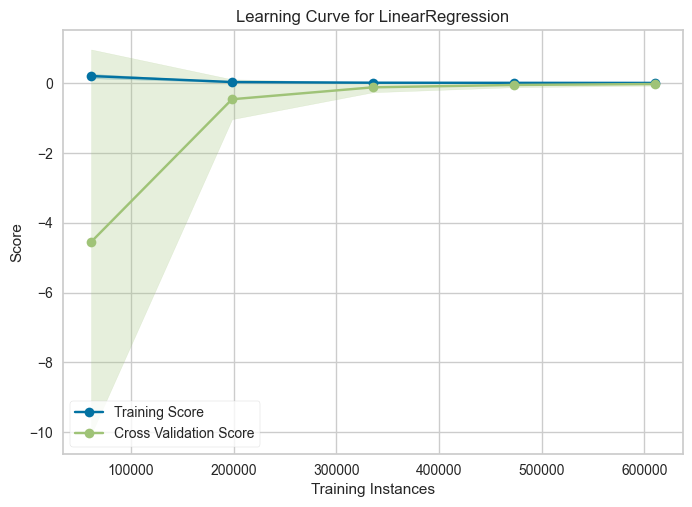

<AxesSubplot: title={'center': 'Learning Curve for LinearRegression'}, xlabel='Training Instances', ylabel='Score'>

In [44]:
# Plot the learning curve
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=lr_regr, cv=cv, scoring='r2',
                           train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(X, y)
visualizer.show()


In [45]:
# Create and train the model
lr_regr.fit(X_train, y_train)


LinearRegression()

In [46]:
# Print the Intercept
print('Intercept:', lr_regr.intercept_, '\n')

# Print Coefficients by descending "importance"
formattedList = [format(float(i), '.6f') for i in lr_regr.coef_]
formattedList2 = [format(abs(float(i)), '.6f') for i in lr_regr.coef_]
data_tuples = list(zip(X.columns, formattedList, formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=[
                        'Feature', 'Coefficient', 'AbsCoefficient'])
coeff_df['AbsCoefficient'] = coeff_df['AbsCoefficient'].astype(float)
coeff_df.sort_values('AbsCoefficient', axis=0, inplace=True, ascending=False)
coeff_df


Intercept: 6.380996551495124 



,Feature,Coefficient,AbsCoefficient
27,Region_R83,-1.047666,1.047666
32,Region_R42,-1.027420,1.027420
12,VehBrand_B14,-1.026848,1.026848
35,Region_R41,-1.017605,1.017605
34,Region_R21,-1.002664,1.002664
...,...,...,...
0,Area_D,-0.413739,0.413739
2,Area_E,-0.343311,0.343311
4,Area_F,-0.243651,0.243651
60,VehGas_Regular,-0.098261,0.098261


In [47]:
# predict y for X_train and X_test
y_pred_train = lr_regr.predict(X_train)
y_pred_test = lr_regr.predict(X_test)


In [48]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE', 'RMSE', 'R^2', 'MAPE (%)', 'MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                   np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                   metricsObj.r2_score(yTrain, yPredTrain),
                   metricsObj.mean_absolute_percentage_error(
      yTrain, yPredTrain),
      metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                  np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                  metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                  metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame(
      {'Measure': measures_list, 'Train': train_results, 'Test': test_results})
  return (resultsDF)


In [49]:
# Show performance results
resultsDF = performanceMetricsDF(
    metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF


,Measure,Train,Test
0,MAE,4.315238e-01,5.344754e-01
1,RMSE,5.456621e-01,6.409332e-01
2,R^2,7.618023e-01,6.713638e-01
3,MAPE (%),5.092996e+14,5.098029e+14
4,MAX Error,3.174981e+00,2.975900e+00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


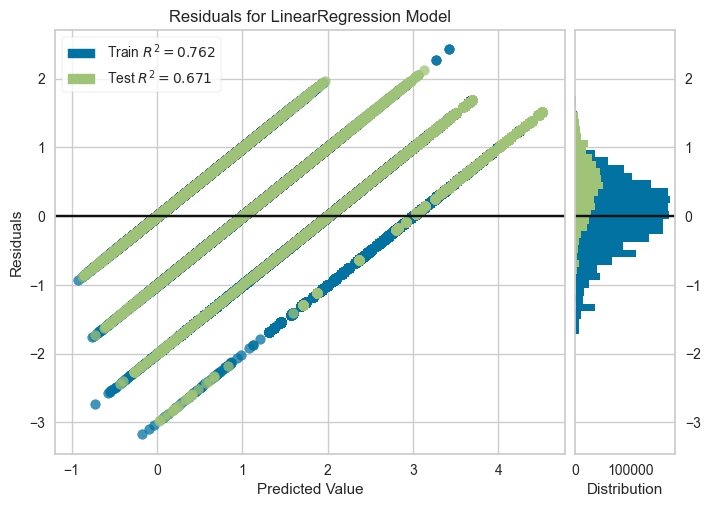

<AxesSubplot: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [50]:
# Visualize the residuals
residuals_vis = ResidualsPlot(lr_regr)
residuals_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test, y_test)  # Evaluate the model on the test data
residuals_vis.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


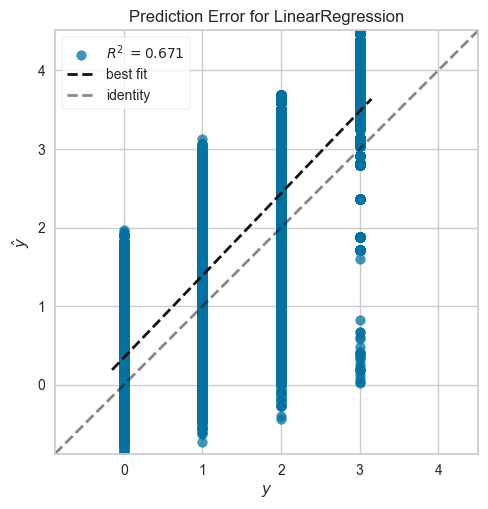

<AxesSubplot: title={'center': 'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [51]:
# Visualize the prediction error
predError_vis = PredictionError(lr_regr)
predError_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test, y_test)  # Evaluate the model on the test data
predError_vis.show()


In [52]:
import pickle
file = open("model_lin.pickle", "wb")
pickle.dump(lr_regr, file)
file.close()


In [53]:
# Load the trained model
file = open("model_lin.pickle", "rb")
lr_regr = pickle.load(file)
file.close()


In [54]:
# Run the prediction
y_pred = lr_regr.predict(X)

# Show predictions
ds_lin['ClaimNb'] = y_pred
ds_lin.tail(15)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,VehAge_binned,Exposure_binned,DrivAge_binned,BonusMalus_binned,VehPower_binned,Density_binned
677998,6114316.0,0.177190,0.18,B,11,2,41,76,B12,Diesel,81,R11,"(0, 2]","(0, 0.18]","(34, 44]","(64, 230]","(7, 15]","(0, 92]"
677999,6114317.0,0.790772,0.18,E,7,2,51,53,B12,Diesel,3240,R11,"(0, 2]","(0, 0.18]","(44, 55]","(49, 64]","(6, 7]","(1658, 28000]"
678000,6114318.0,0.504914,0.18,C,7,2,48,50,B12,Diesel,263,R82,"(0, 2]","(0, 0.18]","(44, 55]","(49, 64]","(6, 7]","(92, 393]"
678001,6114319.0,0.262046,0.18,C,4,2,61,50,B12,Regular,205,R25,"(0, 2]","(0, 0.18]","(55,100]","(49, 64]","(3, 5]","(92, 393]"
678002,6114320.0,0.638401,0.18,E,10,2,29,80,B12,Diesel,2471,R11,"(0, 2]","(0, 0.18]","(17, 34]","(64, 230]","(7, 15]","(1658, 28000]"
678003,6114321.0,0.734633,0.18,E,4,2,29,80,B12,Regular,5360,R11,"(0, 2]","(0, 0.18]","(17, 34]","(64, 230]","(3, 5]","(1658, 28000]"
678004,6114322.0,0.715200,0.18,E,11,2,49,74,B12,Diesel,5360,R11,"(0, 2]","(0, 0.18]","(44, 55]","(64, 230]","(7, 15]","(1658, 28000]"
678005,6114323.0,0.719032,0.18,D,4,2,34,80,B12,Regular,731,R82,"(0, 2]","(0, 0.18]","(17, 34]","(64, 230]","(3, 5]","(393, 1658]"
678006,6114324.0,0.730985,0.18,D,11,2,41,50,B12,Diesel,528,R93,"(0, 2]","(0, 0.18]","(34, 44]","(49, 64]","(7, 15]","(393, 1658]"
678007,6114325.0,0.396155,0.18,E,6,4,40,68,B12,Regular,2733,R93,"(2, 6]","(0, 0.18]","(34, 44]","(64, 230]","(5, 6]","(1658, 28000]"


#### Decision Tree

In [55]:
pip install graphviz


Note: you may need to restart the kernel to use updated packages.


In [56]:
# Create a modeling dataset from the original dataset

X = ds_dt
ds_dt.head()

,Area_D,Area_B,Area_E,Area_C,Area_F,Area_A,VehBrand_B12,VehBrand_B6,VehBrand_B3,VehBrand_B2,...,"BonusMalus_binned_(64, 230]","VehPower_binned_(3, 5]","VehPower_binned_(5, 6]","VehPower_binned_(6, 7]","VehPower_binned_(7, 15]","Density_binned_(0, 92]","Density_binned_(92, 393]","Density_binned_(393, 1658]","Density_binned_(1658, 28000]",VehGas_Regular
0,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [57]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Area_D,678013.0,0.223589,0.416650,0.0,0.0,0.0,0.0,1.0
Area_B,678013.0,0.111294,0.314496,0.0,0.0,0.0,0.0,1.0
Area_E,678013.0,0.202307,0.401720,0.0,0.0,0.0,0.0,1.0
Area_C,678013.0,0.283003,0.450458,0.0,0.0,0.0,1.0,1.0
Area_F,678013.0,0.026480,0.160559,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
"Density_binned_(0, 92]",678013.0,0.250693,0.433412,0.0,0.0,0.0,1.0,1.0
"Density_binned_(92, 393]",678013.0,0.251093,0.433642,0.0,0.0,0.0,1.0,1.0
"Density_binned_(393, 1658]",678013.0,0.248455,0.432118,0.0,0.0,0.0,0.0,1.0
"Density_binned_(1658, 28000]",678013.0,0.249759,0.432874,0.0,0.0,0.0,0.0,1.0


In [58]:
# Summary statistics for all variables after data preparation - Transpose
X.describe(include='all')


,Area_D,Area_B,Area_E,Area_C,Area_F,Area_A,VehBrand_B12,VehBrand_B6,VehBrand_B3,VehBrand_B2,...,"BonusMalus_binned_(64, 230]","VehPower_binned_(3, 5]","VehPower_binned_(5, 6]","VehPower_binned_(6, 7]","VehPower_binned_(7, 15]","Density_binned_(0, 92]","Density_binned_(92, 393]","Density_binned_(393, 1658]","Density_binned_(1658, 28000]",VehGas_Regular
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,...,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,0.223589,0.111294,0.202307,0.283003,0.026480,0.153326,0.244868,0.042105,0.078752,0.235779,...,0.249473,0.354226,0.219724,0.214452,0.211598,0.250693,0.251093,0.248455,0.249759,0.510133
std,0.416650,0.314496,0.401720,0.450458,0.160559,0.360302,0.430010,0.200830,0.269352,0.424485,...,0.432708,0.478279,0.414060,0.410442,0.408441,0.433412,0.433642,0.432118,0.432874,0.499898
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
# Initialize model
tree_regr0 = tree.DecisionTreeRegressor(
    random_state=123, max_depth=4, min_samples_leaf=5)


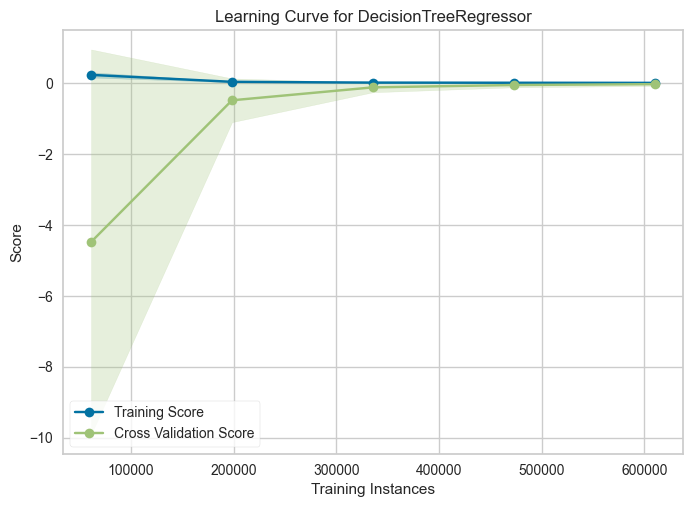

<AxesSubplot: title={'center': 'Learning Curve for DecisionTreeRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [60]:
# Plot the learning curve
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=tree_regr0, cv=cv,
                           scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(X, y)
visualizer.show()


In [61]:
# Create and train the model
tree_regr0.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, random_state=123)

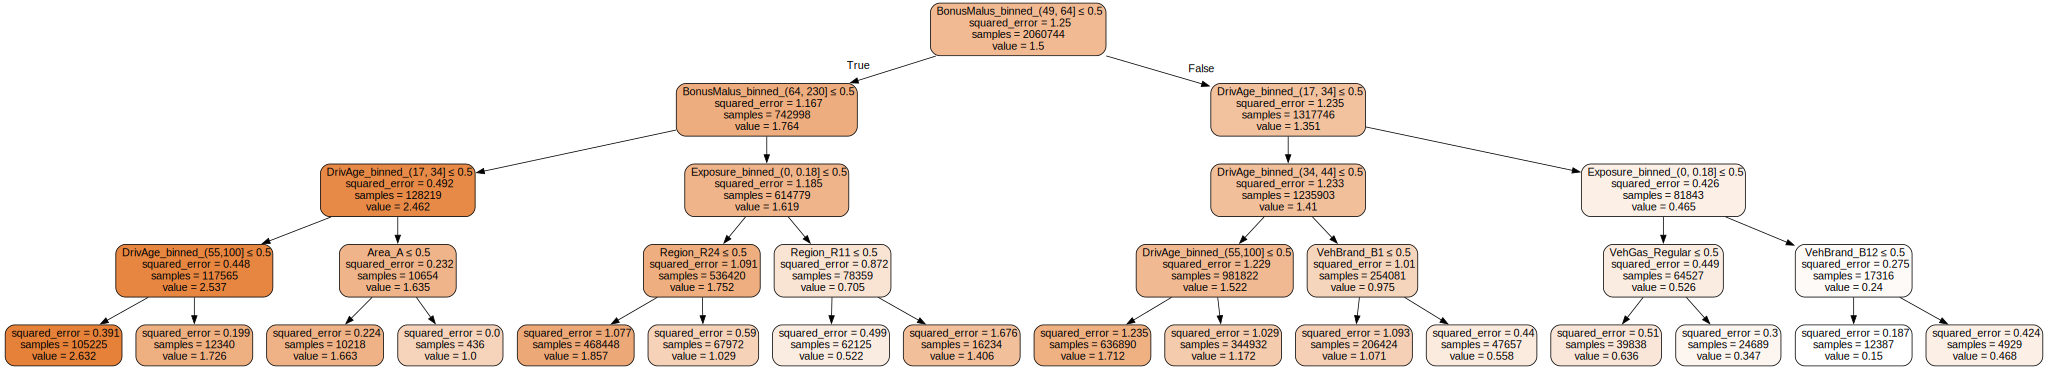

In [62]:
# Plot the tree
# Install Graphviz using "pip install graphviz" or "conda install python-graphviz"
import graphviz
dot_data = tree.export_graphviz(tree_regr0, out_file=None,
                                feature_names=list(X_train.columns),
                                class_names='Returns',
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph


##### 
Hyper Tunning test for the decision tree: The result showed to use max_depth=None with an improvement on test dataset.


In [63]:
# Import necessary modules
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from random import randint

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None] }

# Instantiate a Decision Tree classifier: tree
tree0 = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_regr0 = RandomizedSearchCV(tree0, param_dist, cv=5)

# Fit it to the data
tree_regr0.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions={'max_depth': [3, None]})

In [64]:
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_regr0.best_params_))
print("Best score is {}".format(tree_regr0.best_score_))


Tuned Decision Tree Parameters: {'max_depth': None}
Best score is -0.36367861673939694


In [65]:
# Initialize model using the parameters of the Hyper Tunning (in the end of the code - max_depth=None and min_samples-leaf=1)
tree_regr = tree.DecisionTreeRegressor(
    random_state=123, max_depth=None, min_samples_leaf=5)

# Create and train the model
tree_regr.fit(X_train, y_train)


DecisionTreeRegressor(min_samples_leaf=5, random_state=123)

In [66]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member, '.6f'))
                 for member in tree_regr.feature_importances_]
formattedList2 = [abs(float(format(member, '.6f')))
                  for member in tree_regr.feature_importances_]
data_tuples = list(zip(X.columns, formattedList, formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=[
                        'Feature', 'Coefficient', 'AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df


,Feature,Coefficient,AbsCoefficient
0,Area_D,0.055209,0.055209
48,"DrivAge_binned_(44, 55]",0.055135,0.055135
43,"Exposure_binned_(0, 0.18]",0.045534,0.045534
45,"Exposure_binned_(0.49, 2.1]",0.041030,0.041030
46,"DrivAge_binned_(17, 34]",0.038529,0.038529
...,...,...,...
27,Region_R83,0.000705,0.000705
37,Region_R74,0.000629,0.000629
34,Region_R21,0.000333,0.000333
32,Region_R42,0.000218,0.000218


In [67]:
# predict y for X_train and X_test
y_pred_train = tree_regr.predict(X_train)
y_pred_test = tree_regr.predict(X_test)


In [68]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE', 'RMSE', 'R^2', 'MAPE (%)', 'MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                   np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                   metricsObj.r2_score(yTrain, yPredTrain),
                   metricsObj.mean_absolute_percentage_error(
      yTrain, yPredTrain),
      metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                  np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                  metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                  metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame(
      {'Measure': measures_list, 'Train': train_results, 'Test': test_results})
  return (resultsDF)


In [69]:
# Show performance results
resultsDF = performanceMetricsDF(
    metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF


,Measure,Train,Test
0,MAE,1.029441e-01,4.900800e-01
1,RMSE,2.397952e-01,7.599751e-01
2,R^2,9.539986e-01,5.379503e-01
3,MAPE (%),1.945773e+14,2.202311e+14
4,MAX Error,2.999161e+00,3.000000e+00


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


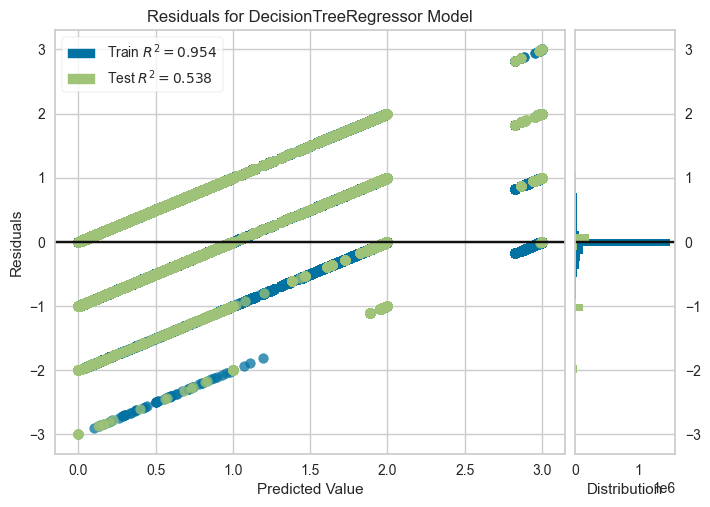

<AxesSubplot: title={'center': 'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [70]:
# Visualize the residuals
residuals_vis = ResidualsPlot(tree_regr)
residuals_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test, y_test)  # Evaluate the model on the test data
residuals_vis.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


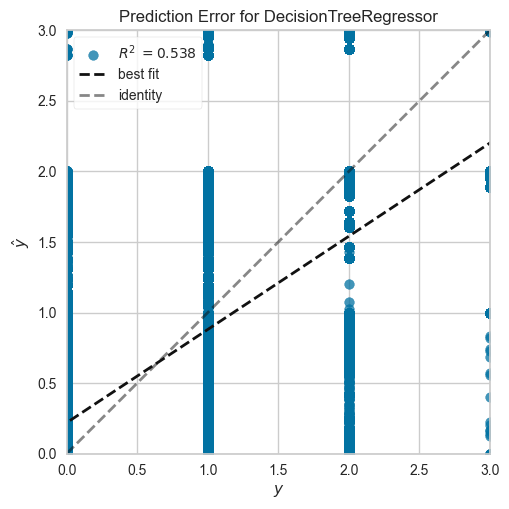

<AxesSubplot: title={'center': 'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [71]:
# Visualize the prediction error
predError_vis = PredictionError(tree_regr)
predError_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test, y_test)  # Evaluate the model on the test data
predError_vis.show()


In [72]:
import pickle
file = open("model_dt.pickle", "wb")
pickle.dump(tree_regr, file)
file.close()


### Evaluation

Crisp-DM: it is important to thoroughly evaluate it and review
the steps executed to create it, to be certain the model properly achieves the business objectives. A key objective is
to determine if there is some important business issue that has not been sufficiently considered. At the end of this
phase, a decision on the use of the data mining results should be reached.

Considering the R^2 in the train dataset the group noticed that Linear Regression gave better results than Decision Tree. We will have to run the Crisp-DM cycle again choosing another ML methods. Also the prediction for ClaimNb is showng numbers below 1 which makes more sense.





#### Deployment

Crisp-DM: Depending on the requirements, the
deployment phase can be as simple as generating a report or as complex as implementing a repeatable data mining
process across the enterprise. In many cases, it is the customer, not the data analyst, who carries out the deployment
steps. However, even if the analyst will carry out the deployment effort, it is important for the customer to understand
up front what actions need to be carried out in order to actually make use of the created models.

The group XB decide to deliver a report showing the prediction of Claims for the next year. Tha will be evaluated by the client with the business experience. A good benchmark is to make a comparison with the traditional way of planning and see if fits with the machine learning process.

In [73]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
import pickle


In [74]:
# Load the trained model
file = open("model_dt.pickle", "rb")
tree_regr = pickle.load(file)
file.close()


In [75]:
X.describe(include='all').T


,count,mean,std,min,25%,50%,75%,max
Area_D,678013.0,0.223589,0.416650,0.0,0.0,0.0,0.0,1.0
Area_B,678013.0,0.111294,0.314496,0.0,0.0,0.0,0.0,1.0
Area_E,678013.0,0.202307,0.401720,0.0,0.0,0.0,0.0,1.0
Area_C,678013.0,0.283003,0.450458,0.0,0.0,0.0,1.0,1.0
Area_F,678013.0,0.026480,0.160559,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
"Density_binned_(0, 92]",678013.0,0.250693,0.433412,0.0,0.0,0.0,1.0,1.0
"Density_binned_(92, 393]",678013.0,0.251093,0.433642,0.0,0.0,0.0,1.0,1.0
"Density_binned_(393, 1658]",678013.0,0.248455,0.432118,0.0,0.0,0.0,0.0,1.0
"Density_binned_(1658, 28000]",678013.0,0.249759,0.432874,0.0,0.0,0.0,0.0,1.0


In [76]:
# Run the prediction
y_pred = tree_regr.predict(X)


In [77]:
# Show predictions
ds_lin['ClaimNb'] = y_pred
ds_lin.tail(15)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,VehAge_binned,Exposure_binned,DrivAge_binned,BonusMalus_binned,VehPower_binned,Density_binned
677998,6114316.0,0.222222,0.18,B,11,2,41,76,B12,Diesel,81,R11,"(0, 2]","(0, 0.18]","(34, 44]","(64, 230]","(7, 15]","(0, 92]"
677999,6114317.0,0.261905,0.18,E,7,2,51,53,B12,Diesel,3240,R11,"(0, 2]","(0, 0.18]","(44, 55]","(49, 64]","(6, 7]","(1658, 28000]"
678000,6114318.0,0.000000,0.18,C,7,2,48,50,B12,Diesel,263,R82,"(0, 2]","(0, 0.18]","(44, 55]","(49, 64]","(6, 7]","(92, 393]"
678001,6114319.0,0.850467,0.18,C,4,2,61,50,B12,Regular,205,R25,"(0, 2]","(0, 0.18]","(55,100]","(49, 64]","(3, 5]","(92, 393]"
678002,6114320.0,0.000000,0.18,E,10,2,29,80,B12,Diesel,2471,R11,"(0, 2]","(0, 0.18]","(17, 34]","(64, 230]","(7, 15]","(1658, 28000]"
678003,6114321.0,1.195635,0.18,E,4,2,29,80,B12,Regular,5360,R11,"(0, 2]","(0, 0.18]","(17, 34]","(64, 230]","(3, 5]","(1658, 28000]"
678004,6114322.0,0.311111,0.18,E,11,2,49,74,B12,Diesel,5360,R11,"(0, 2]","(0, 0.18]","(44, 55]","(64, 230]","(7, 15]","(1658, 28000]"
678005,6114323.0,0.796680,0.18,D,4,2,34,80,B12,Regular,731,R82,"(0, 2]","(0, 0.18]","(17, 34]","(64, 230]","(3, 5]","(393, 1658]"
678006,6114324.0,0.146341,0.18,D,11,2,41,50,B12,Diesel,528,R93,"(0, 2]","(0, 0.18]","(34, 44]","(49, 64]","(7, 15]","(393, 1658]"
678007,6114325.0,0.000000,0.18,E,6,4,40,68,B12,Regular,2733,R93,"(2, 6]","(0, 0.18]","(34, 44]","(64, 230]","(5, 6]","(1658, 28000]"
